In [1]:
import warnings
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

# imports de modulos que estao definidos dentro do projeto
import data
import arima
import timeseries

import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,0,'Ano')

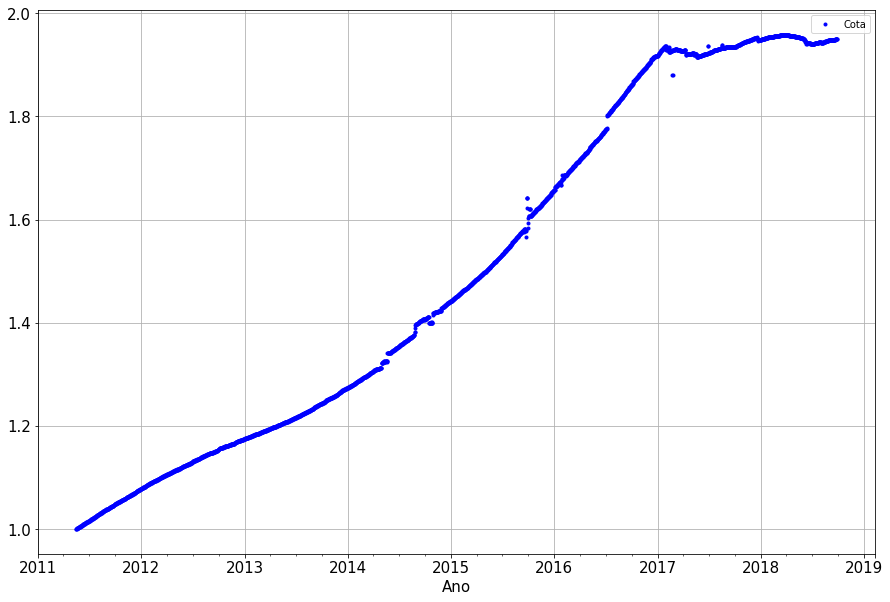

In [2]:
timeseries02_daily = data.load_timeseries02_daily()

timeseries02_daily.plot(figsize=(15, 10), linewidth=2, fontsize=15, style='b.')
plt.grid(True)
plt.xlabel('Ano', fontsize=15)

Text(0.5,0,'Ano')

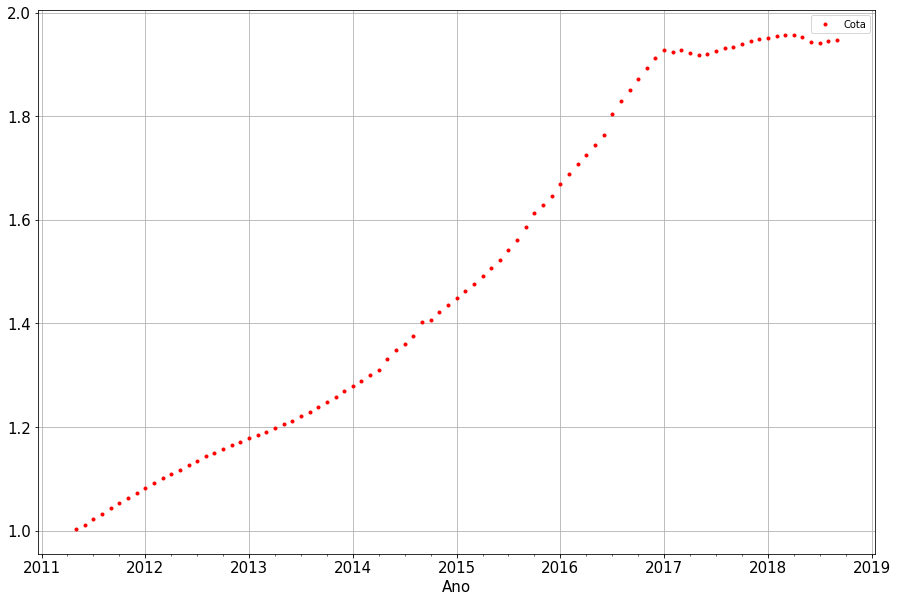

In [3]:
timeseries02_monthly = data.load_timeseries02_monthly()

timeseries02_monthly.plot(figsize=(15, 10), linewidth=2, fontsize=15, style='r.')
plt.grid(True)
plt.xlabel('Ano', fontsize=15)

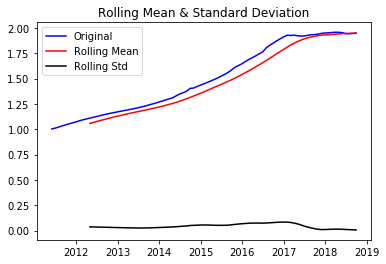

Results of Dickey-Fuller Test:
Test Statistic (-1.037377) > Critical Value 1 (-3.509736)
Test Statistic (-1.037377) > Critical Value 5 (-2.896195)
Test Statistic (-1.037377) > Critical Value 10 (-2.585258)
p-value (0.739389) > 0.05


In [4]:
timeseries.check_stationarity(timeseries02_monthly, window=12)

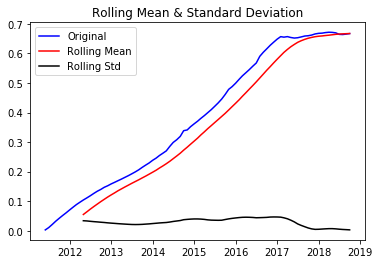

Results of Dickey-Fuller Test:
Test Statistic (-1.239419) > Critical Value 1 (-3.509736)
Test Statistic (-1.239419) > Critical Value 5 (-2.896195)
Test Statistic (-1.239419) > Critical Value 10 (-2.585258)
p-value (0.656413) > 0.05


In [5]:
# Apply a nonlinear log transformation
# Log Scale Transformation
timeseries02_monthly_log = np.log(timeseries02_monthly)
timeseries.check_stationarity(timeseries02_monthly_log, window=12)

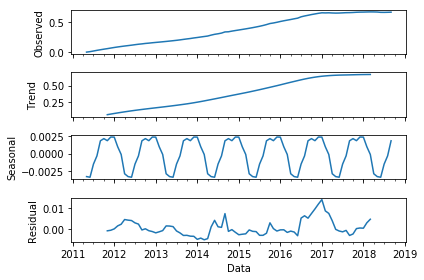

In [6]:
result = seasonal_decompose(timeseries02_monthly_log, model='additive')
#result = seasonal_decompose(timeseries02_monthly_log, model='multiplicative')
result.plot()
plt.show()

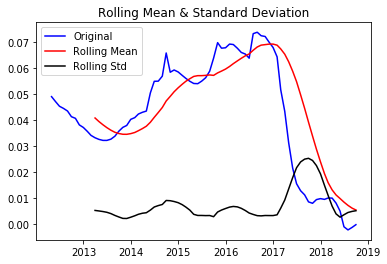

Results of Dickey-Fuller Test:
Test Statistic (-1.610162) > Critical Value 1 (-3.521980)
Test Statistic (-1.610162) > Critical Value 5 (-2.901470)
Test Statistic (-1.610162) > Critical Value 10 (-2.588072)
p-value (0.477891) > 0.05


In [7]:
movingAverage = timeseries02_monthly_log.rolling(window=12).mean()
t1 = timeseries02_monthly_log - movingAverage
t1.dropna(inplace=True)
timeseries.check_stationarity(t1, window=12)

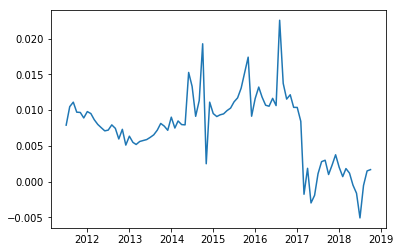

In [8]:
# Remove trend and seasonality with differencing
# Time Shift Transformation 
ts_euro_week_log_diff = timeseries02_monthly_log - timeseries02_monthly_log.shift()
plt.plot(ts_euro_week_log_diff)

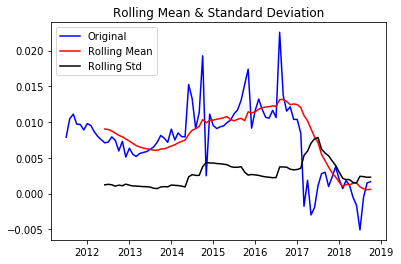

Results of Dickey-Fuller Test:
Test Statistic (-1.513348) > Critical Value 1 (-3.509736)
Test Statistic (-1.513348) > Critical Value 5 (-2.896195)
Test Statistic (-1.513348) > Critical Value 10 (-2.585258)
p-value (0.526898) > 0.05


In [9]:
ts_euro_week_log_diff.dropna(inplace=True)
timeseries.check_stationarity(ts_euro_week_log_diff, window=12)

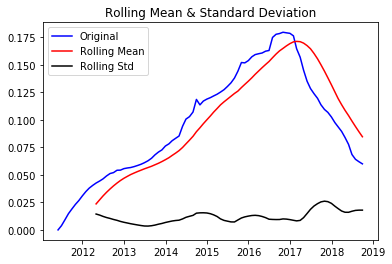

Results of Dickey-Fuller Test:
Test Statistic (-1.609684) > Critical Value 1 (-3.509736)
Test Statistic (-1.609684) > Critical Value 5 (-2.896195)
Test Statistic (-1.609684) > Critical Value 10 (-2.585258)
p-value (0.478727) > 0.05


In [10]:
#Exponential Decay Transformation
exponentialDecayWeightedAverage = timeseries02_monthly_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
datasetLogScaleMinusExponentialMovingAverage = timeseries02_monthly_log - exponentialDecayWeightedAverage
timeseries.check_stationarity(datasetLogScaleMinusExponentialMovingAverage, window=12)

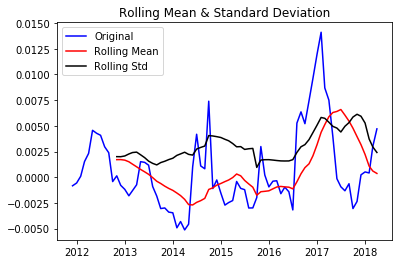

Results of Dickey-Fuller Test:
Test Statistic (-2.722454) > Critical Value 1 (-3.519481)
Test Statistic (-2.722454) > Critical Value 5 (-2.900395)
Test Statistic (-2.722454) < Critical Value 10 (-2.587498)
p-value (0.070233) > 0.05


In [11]:
decomposition = seasonal_decompose(timeseries02_monthly_log) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
timeseries.check_stationarity(decomposedLogData, window=12)

In [12]:
warnings.filterwarnings("ignore")

arima_params = arima.get_arima_params(
    p_values=range(0, 3),
    d_values=range(0, 2),
    q_values=range(0, 2))
#print(len(arima_params))

#arima.evaluate_models(timeseries02_monthly.values, arima_params)
#arima.evaluate_models(decomposedLogData.values, arima_params)

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#X = timeseries02_monthly.values
X = decomposedLogData.values

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()


model = ARIMA(history, order=(2, 1, 1))
model_fit = model.fit(disp=0)
#output = model_fit.forecast()
forecast = model_fit.forecast(steps=len(test))[0]
#print(forecast)
#print(type(forecast))

for yhat in forecast:
    predictions.append(yhat)
    obs = test[t]
    #print('predicted=%f, expected=%f' % (yhat, obs))

print(predictions)
#print(len(predictions))
#print(len(test))

error = mean_squared_error(test, predictions)
print('Test MSE: %.9f' % error)

plt.figure(figsize=(20, 15))
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
plt.show()

NameError: name 't' is not defined